In [2]:
import numpy as np
import sympy as sym
from scipy import linalg
import json
import matplotlib.pyplot as plt
from ae483tools import *

# 1. Test Flights With Motion Capture Data

## 1.1 Short Takeoff to 0.5 meters

We modified the `flight.py` code to include the initially measured motion capture data, attempting to fly the drone to a position 0.5m above its initial position.

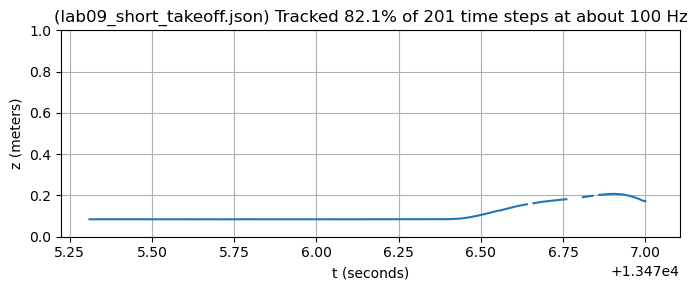

In [ ]:
check_mocap_coverage("lab09_short_takeoff_fix.json")

In [4]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab09_short_takeoff.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'], do_transform=False)

# Only look at data from when the drone was actually flying
# only_in_flight(data_drone, data_mocap=data_mocap)

In [5]:
# Drone data
# time
t = data_drone['time']
# states
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']
v_x = data_drone['ae483log.v_x']
v_y = data_drone['ae483log.v_y']
v_z = data_drone['ae483log.v_z']
# inputs
w_x = data_drone['ae483log.w_x']
w_y = data_drone['ae483log.w_y']
w_z = data_drone['ae483log.w_z']
a_z = data_drone['ae483log.a_z']
# outputs
n_x = data_drone['ae483log.n_x']
n_y = data_drone['ae483log.n_y']
r = data_drone['ae483log.r']
# Logged mocap data
p_x_mocap_logged = data_drone['ae483log.p_x_mocap']
p_y_mocap_logged = data_drone['ae483log.p_y_mocap']
p_z_mocap_logged = data_drone['ae483log.p_z_mocap']
psi_mocap_logged = data_drone['ae483log.psi_mocap']
theta_mocap_logged = data_drone['ae483log.theta_mocap']
phi_mocap_logged = data_drone['ae483log.phi_mocap']

# state estimates from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])
v_x_inW_default = data_drone['stateEstimate.vx']    # <-- WARNING: in world frame
v_y_inW_default = data_drone['stateEstimate.vy']    # <-- WARNING: in world frame
v_z_inW_default = data_drone['stateEstimate.vz']    # <-- WARNING: in world frame

# Mocap data
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']



In [6]:
mocap_color = 'C0'
mocap_linestyle = '-'
mocap_linewidth = 2

default_color = 'C1'
default_linestyle = '--'
default_linewidth = 2

desired_color = 'C2'
desired_linestyle = ':'
desired_linewidth = 4

custom_color = 'C3'
custom_linestyle = '-.'
custom_linewidth = 3

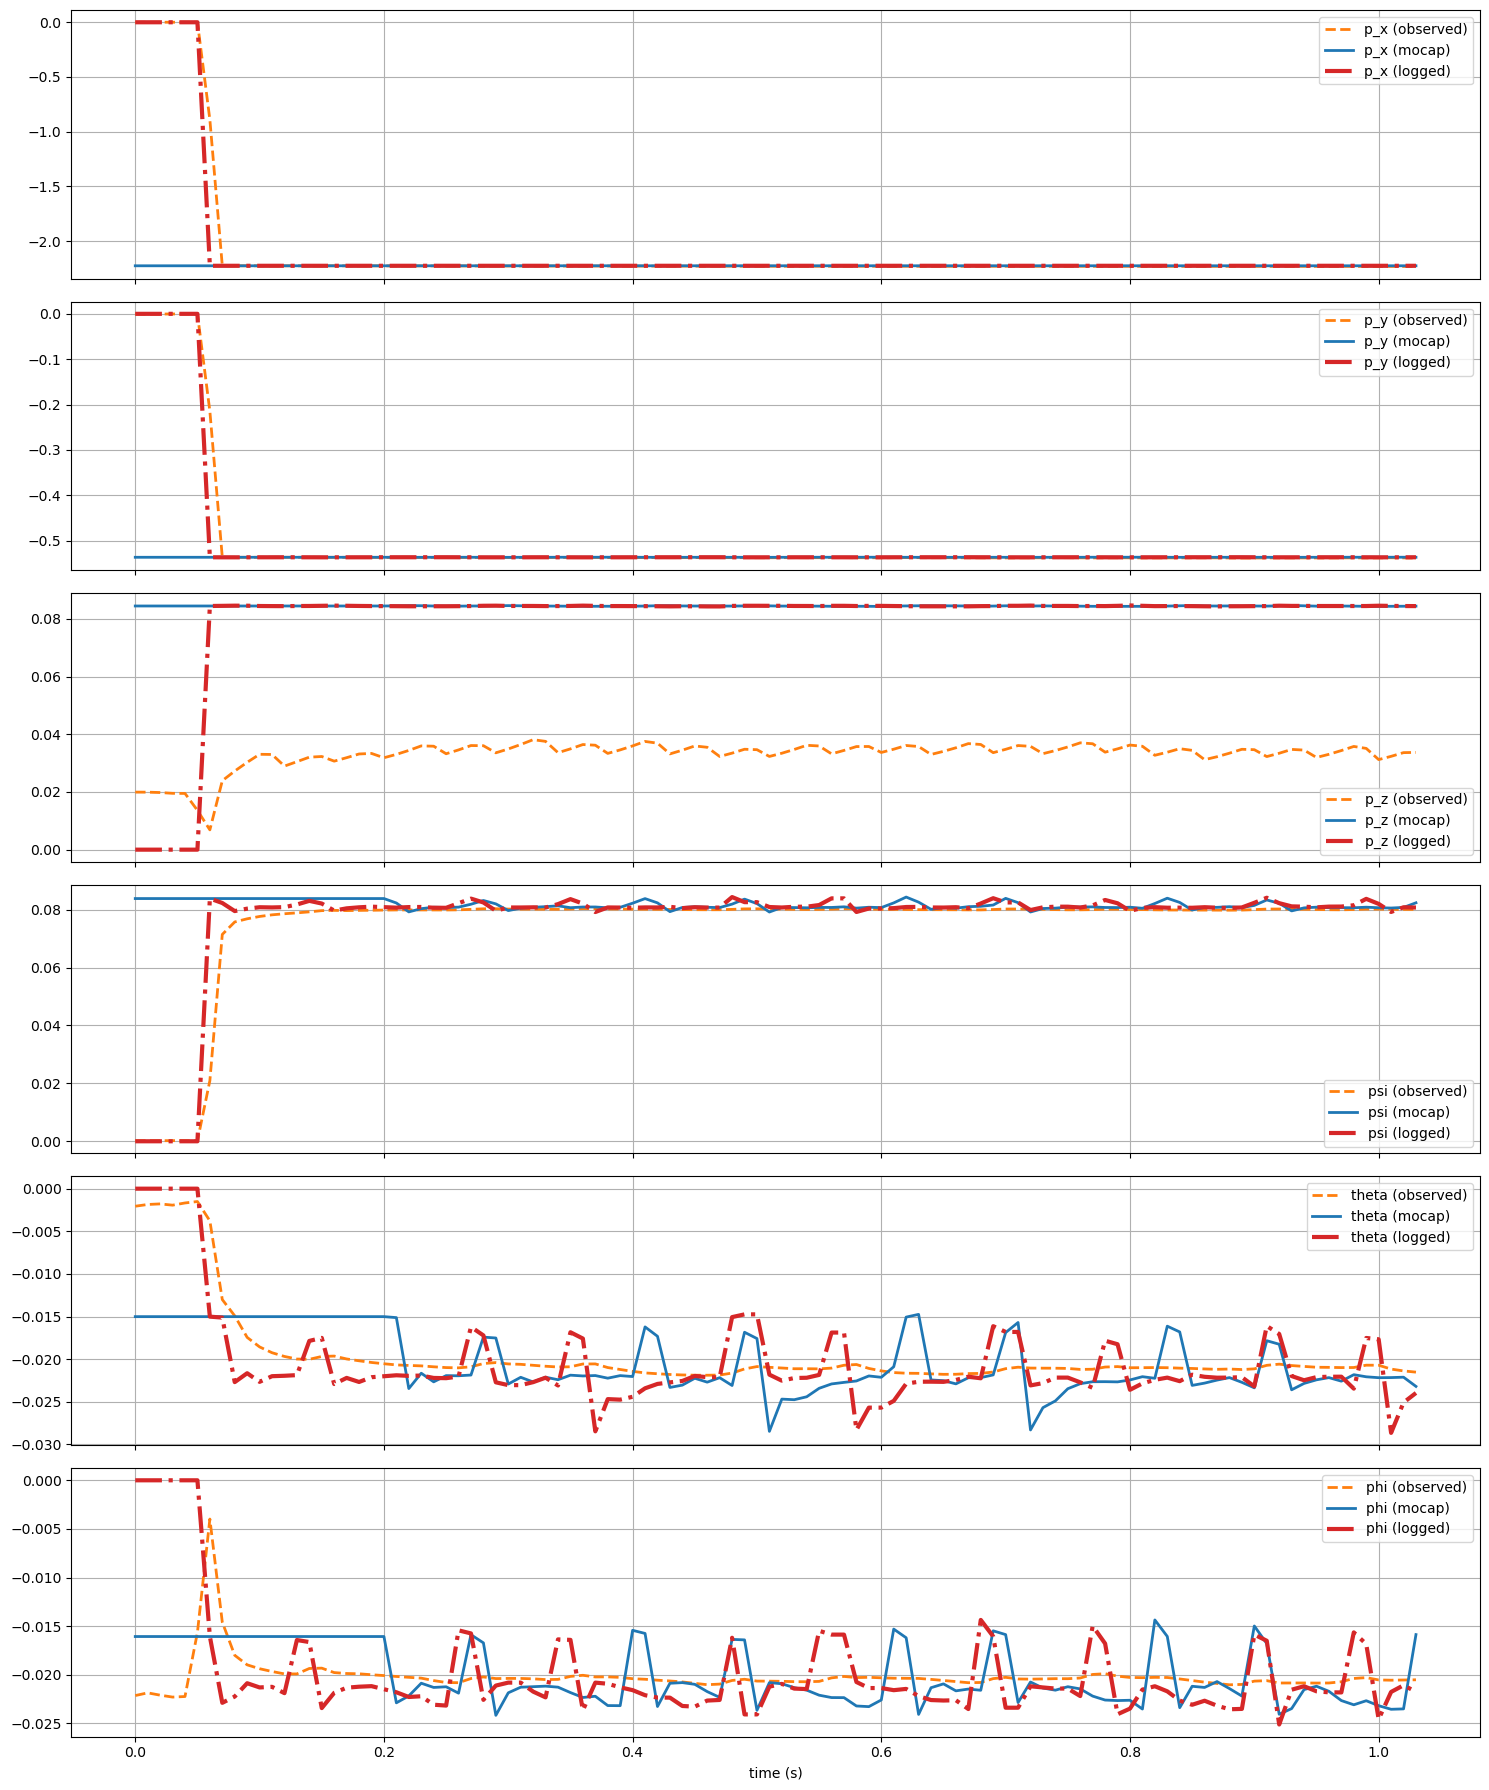

In [7]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (observed)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (logged)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_mocap_logged, p_x_default, p_x_mocap, 'p_x', ax_p_x)
comparison_plot(t, p_y_mocap_logged, p_y_default, p_y_mocap, 'p_y', ax_p_y)
comparison_plot(t, p_z_mocap_logged, p_z_default, p_z_mocap, 'p_z', ax_p_z)
comparison_plot(t, psi_mocap_logged, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_mocap_logged, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_mocap_logged, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

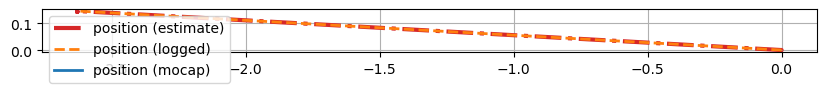

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(p_x_default, p_y_default, label='position (estimate)',
         color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
ax.plot(p_x_mocap_logged, p_y_mocap_logged, label='position (logged)',
         color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
# ax.plot(p_x_des, p_y_des, label='position (desired)',
#          color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
ax.plot(p_x_mocap, p_y_mocap, label='position (mocap)',
         color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

To test the drone's ability to correct its state estimate using motion capture data, we had the drone do a short takeoff flight to 0.5 meters. This flight resulted in the drone quickly losing control and flipping over. Upon further inspection, it was revealed that the drone's state estimate was far from the motion capture system's estimate of its position and showed a lot of oscillation. We suspect that this is because the state we want to fly to is very far from the drone's initial state in the $z$ direction. The drone is then overcorrecting for its error in estimate and unable to achieve stable flight because it is attempting to correct so much.

## 1.2 Short Takeoff to 0.1 meters

To test the drone's ability to correct its state estimate using motion capture data, we decicded to do a short takeoff of 0.1 meter to show that the drone's able to stablize itself with a lower target height.

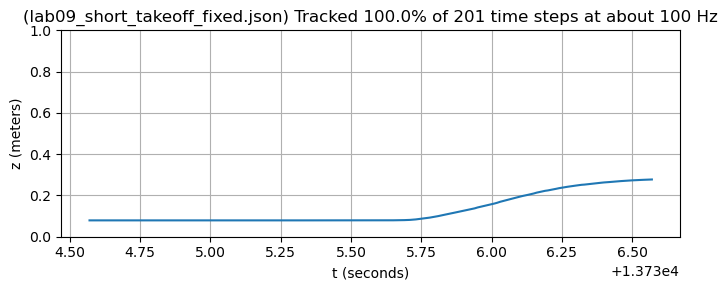

In [16]:
check_mocap_coverage("lab09_short_takeoff_fixed.json")

In [17]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab09_short_takeoff_fixed.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'], do_transform=False)

# Only look at data from when the drone was actually flying
# only_in_flight(data_drone, data_mocap=data_mocap)

In [18]:
# Drone data
# time
t = data_drone['time']
# states
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']
v_x = data_drone['ae483log.v_x']
v_y = data_drone['ae483log.v_y']
v_z = data_drone['ae483log.v_z']
# inputs
w_x = data_drone['ae483log.w_x']
w_y = data_drone['ae483log.w_y']
w_z = data_drone['ae483log.w_z']
a_z = data_drone['ae483log.a_z']
# outputs
n_x = data_drone['ae483log.n_x']
n_y = data_drone['ae483log.n_y']
r = data_drone['ae483log.r']
# Logged mocap data
p_x_mocap_logged = data_drone['ae483log.p_x_mocap']
p_y_mocap_logged = data_drone['ae483log.p_y_mocap']
p_z_mocap_logged = data_drone['ae483log.p_z_mocap']
psi_mocap_logged = data_drone['ae483log.psi_mocap']
theta_mocap_logged = data_drone['ae483log.theta_mocap']
phi_mocap_logged = data_drone['ae483log.phi_mocap']

# state estimates from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])
v_x_inW_default = data_drone['stateEstimate.vx']    # <-- WARNING: in world frame
v_y_inW_default = data_drone['stateEstimate.vy']    # <-- WARNING: in world frame
v_z_inW_default = data_drone['stateEstimate.vz']    # <-- WARNING: in world frame

# Mocap data
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']



In [19]:
mocap_color = 'C0'
mocap_linestyle = '-'
mocap_linewidth = 2

default_color = 'C1'
default_linestyle = '--'
default_linewidth = 2

desired_color = 'C2'
desired_linestyle = ':'
desired_linewidth = 4

custom_color = 'C3'
custom_linestyle = '-.'
custom_linewidth = 3

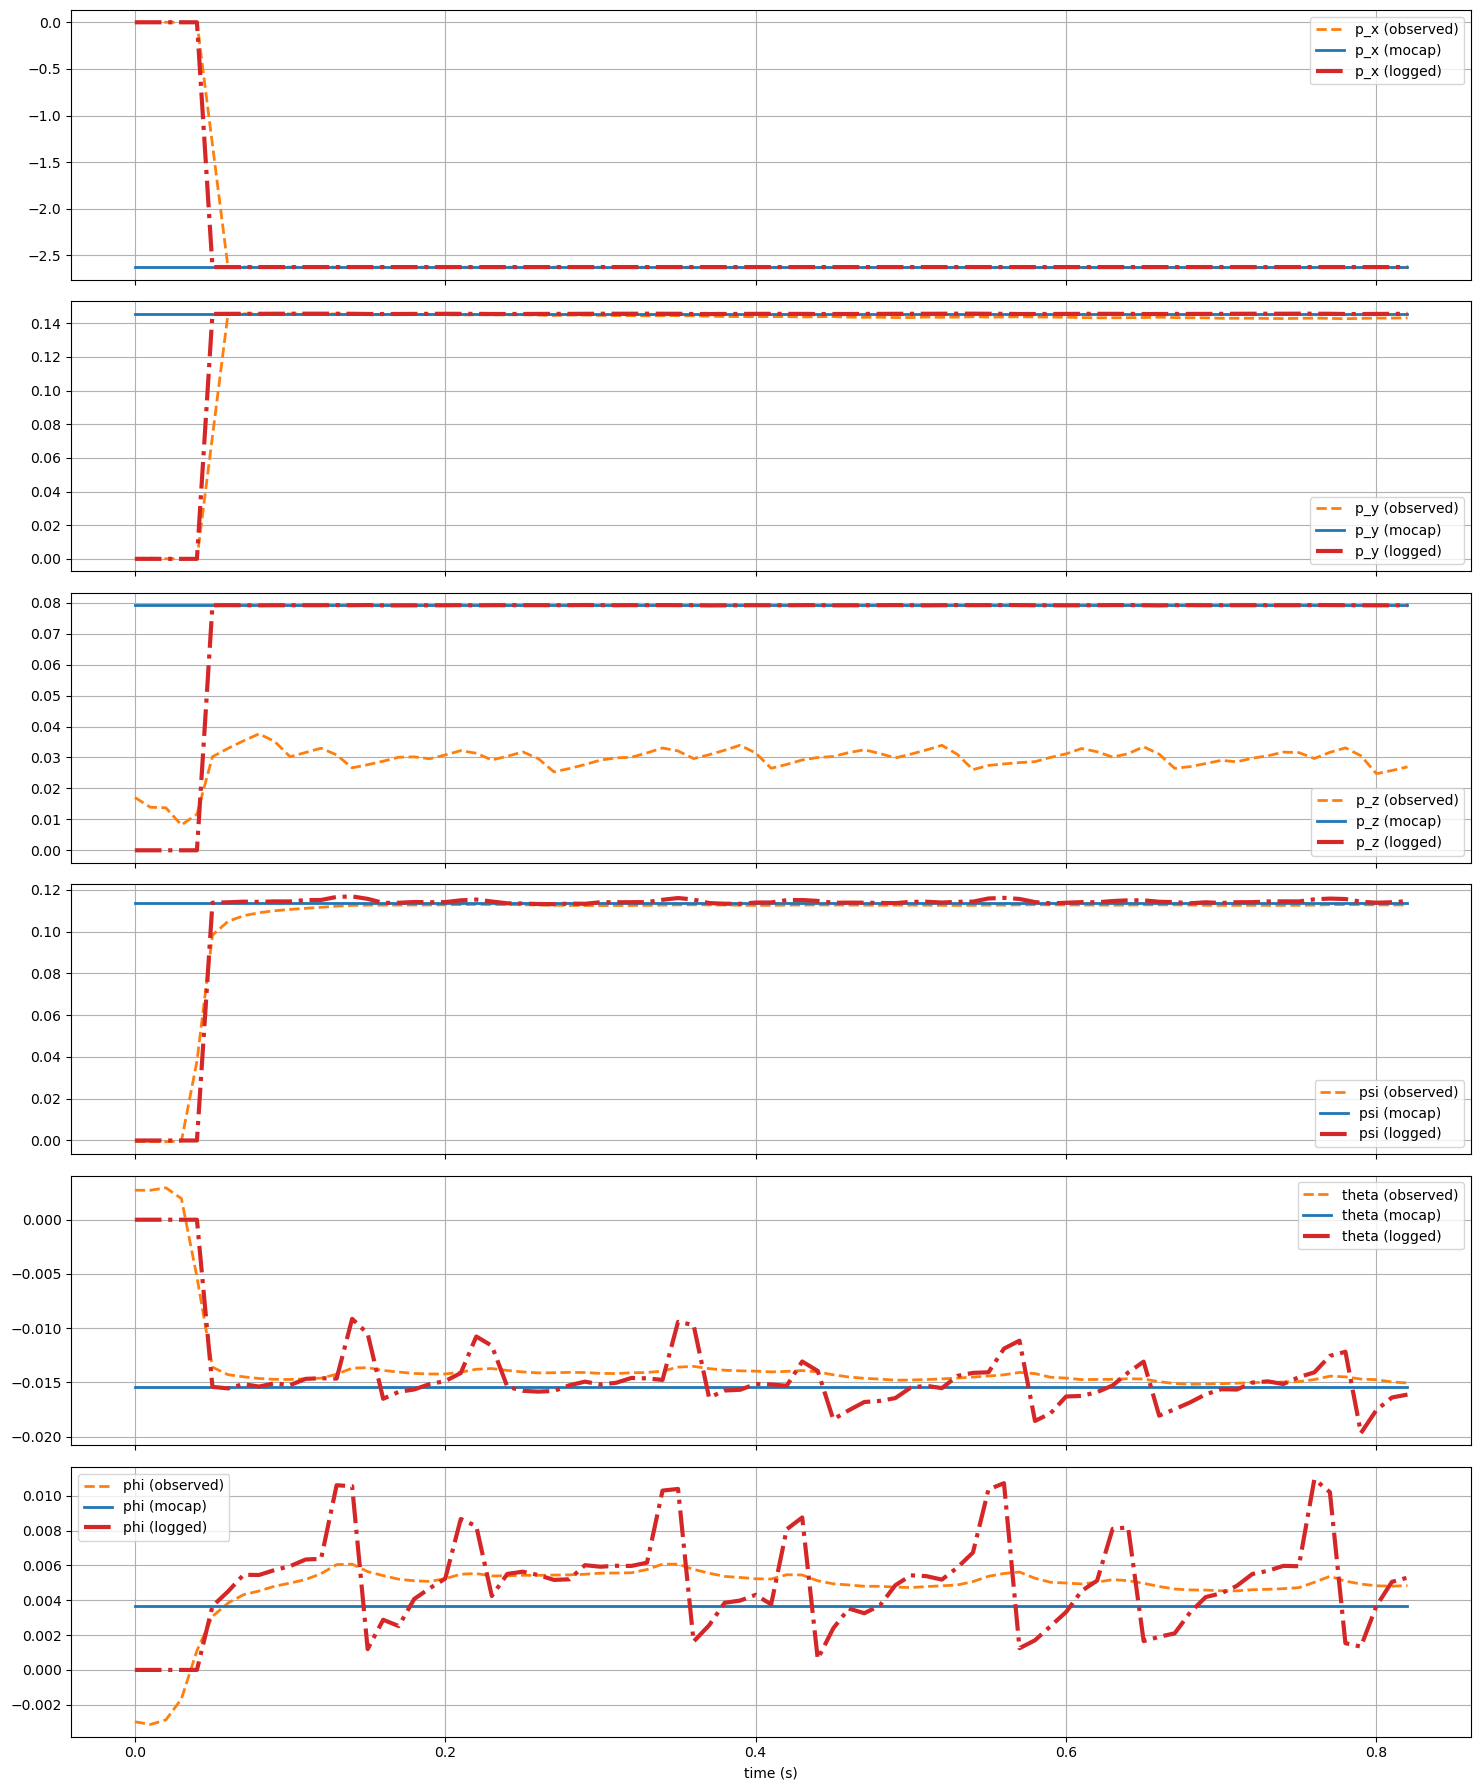

In [20]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (observed)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (logged)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_mocap_logged, p_x_default, p_x_mocap, 'p_x', ax_p_x)
comparison_plot(t, p_y_mocap_logged, p_y_default, p_y_mocap, 'p_y', ax_p_y)
comparison_plot(t, p_z_mocap_logged, p_z_default, p_z_mocap, 'p_z', ax_p_z)
comparison_plot(t, psi_mocap_logged, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_mocap_logged, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_mocap_logged, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

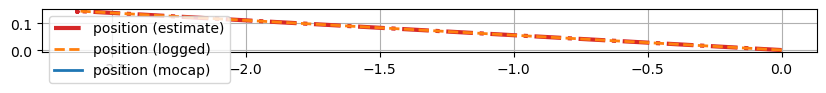

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(p_x, p_y, label='position (estimate)',
         color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
ax.plot(p_x_mocap_logged, p_y_mocap_logged, label='position (logged)',
         color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
# ax.plot(p_x_des, p_y_des, label='position (desired)',
#          color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
ax.plot(p_x_mocap, p_y_mocap, label='position (mocap)',
         color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()

## 1.3 Short Takeoff to 0.1 meters with Custom Observer

Now, we turn on our custom observer to try to achieve stable flight with it.

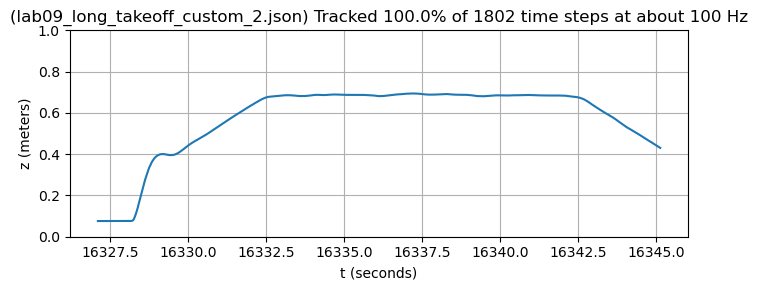

In [32]:
check_mocap_coverage("lab09_long_takeoff_custom_2.json")

In [38]:
# Load flight data
raw_data_drone, raw_data_mocap = load_hardware_data('lab09_long_takeoff_custom_2.json')

# Resample drone data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=0., # <-- FIXME
    t_max_offset=0., # <-- FIXME
)

# Sync and resample mocap data
data_mocap = sync_data_mocap(raw_data_mocap, data_drone['time'], data_drone['ae483log.p_z'], do_transform=False)

# Only look at data from when the drone was actually flying
# only_in_flight(data_drone, data_mocap=data_mocap)

In [39]:
# Drone data
# time
t = data_drone['time']
# states
p_x = data_drone['ae483log.p_x']
p_y = data_drone['ae483log.p_y']
p_z = data_drone['ae483log.p_z']
psi = data_drone['ae483log.psi']
theta = data_drone['ae483log.theta']
phi = data_drone['ae483log.phi']
v_x = data_drone['ae483log.v_x']
v_y = data_drone['ae483log.v_y']
v_z = data_drone['ae483log.v_z']
# inputs
w_x = data_drone['ae483log.w_x']
w_y = data_drone['ae483log.w_y']
w_z = data_drone['ae483log.w_z']
a_z = data_drone['ae483log.a_z']
# outputs
n_x = data_drone['ae483log.n_x']
n_y = data_drone['ae483log.n_y']
r = data_drone['ae483log.r']
# Logged mocap data
p_x_mocap_logged = data_drone['ae483log.p_x_mocap']
p_y_mocap_logged = data_drone['ae483log.p_y_mocap']
p_z_mocap_logged = data_drone['ae483log.p_z_mocap']
psi_mocap_logged = data_drone['ae483log.psi_mocap']
theta_mocap_logged = data_drone['ae483log.theta_mocap']
phi_mocap_logged = data_drone['ae483log.phi_mocap']

# state estimates from default observer
p_x_default = data_drone['stateEstimate.x']
p_y_default = data_drone['stateEstimate.y']
p_z_default = data_drone['stateEstimate.z']
psi_default = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_default = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_default = np.deg2rad(data_drone['stateEstimate.roll'])
v_x_inW_default = data_drone['stateEstimate.vx']    # <-- WARNING: in world frame
v_y_inW_default = data_drone['stateEstimate.vy']    # <-- WARNING: in world frame
v_z_inW_default = data_drone['stateEstimate.vz']    # <-- WARNING: in world frame

# Mocap data
p_x_mocap = data_mocap['x']
p_y_mocap = data_mocap['y']
p_z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']



In [40]:
mocap_color = 'C0'
mocap_linestyle = '-'
mocap_linewidth = 2

default_color = 'C1'
default_linestyle = '--'
default_linewidth = 2

desired_color = 'C2'
desired_linestyle = ':'
desired_linewidth = 4

custom_color = 'C3'
custom_linestyle = '-.'
custom_linewidth = 3

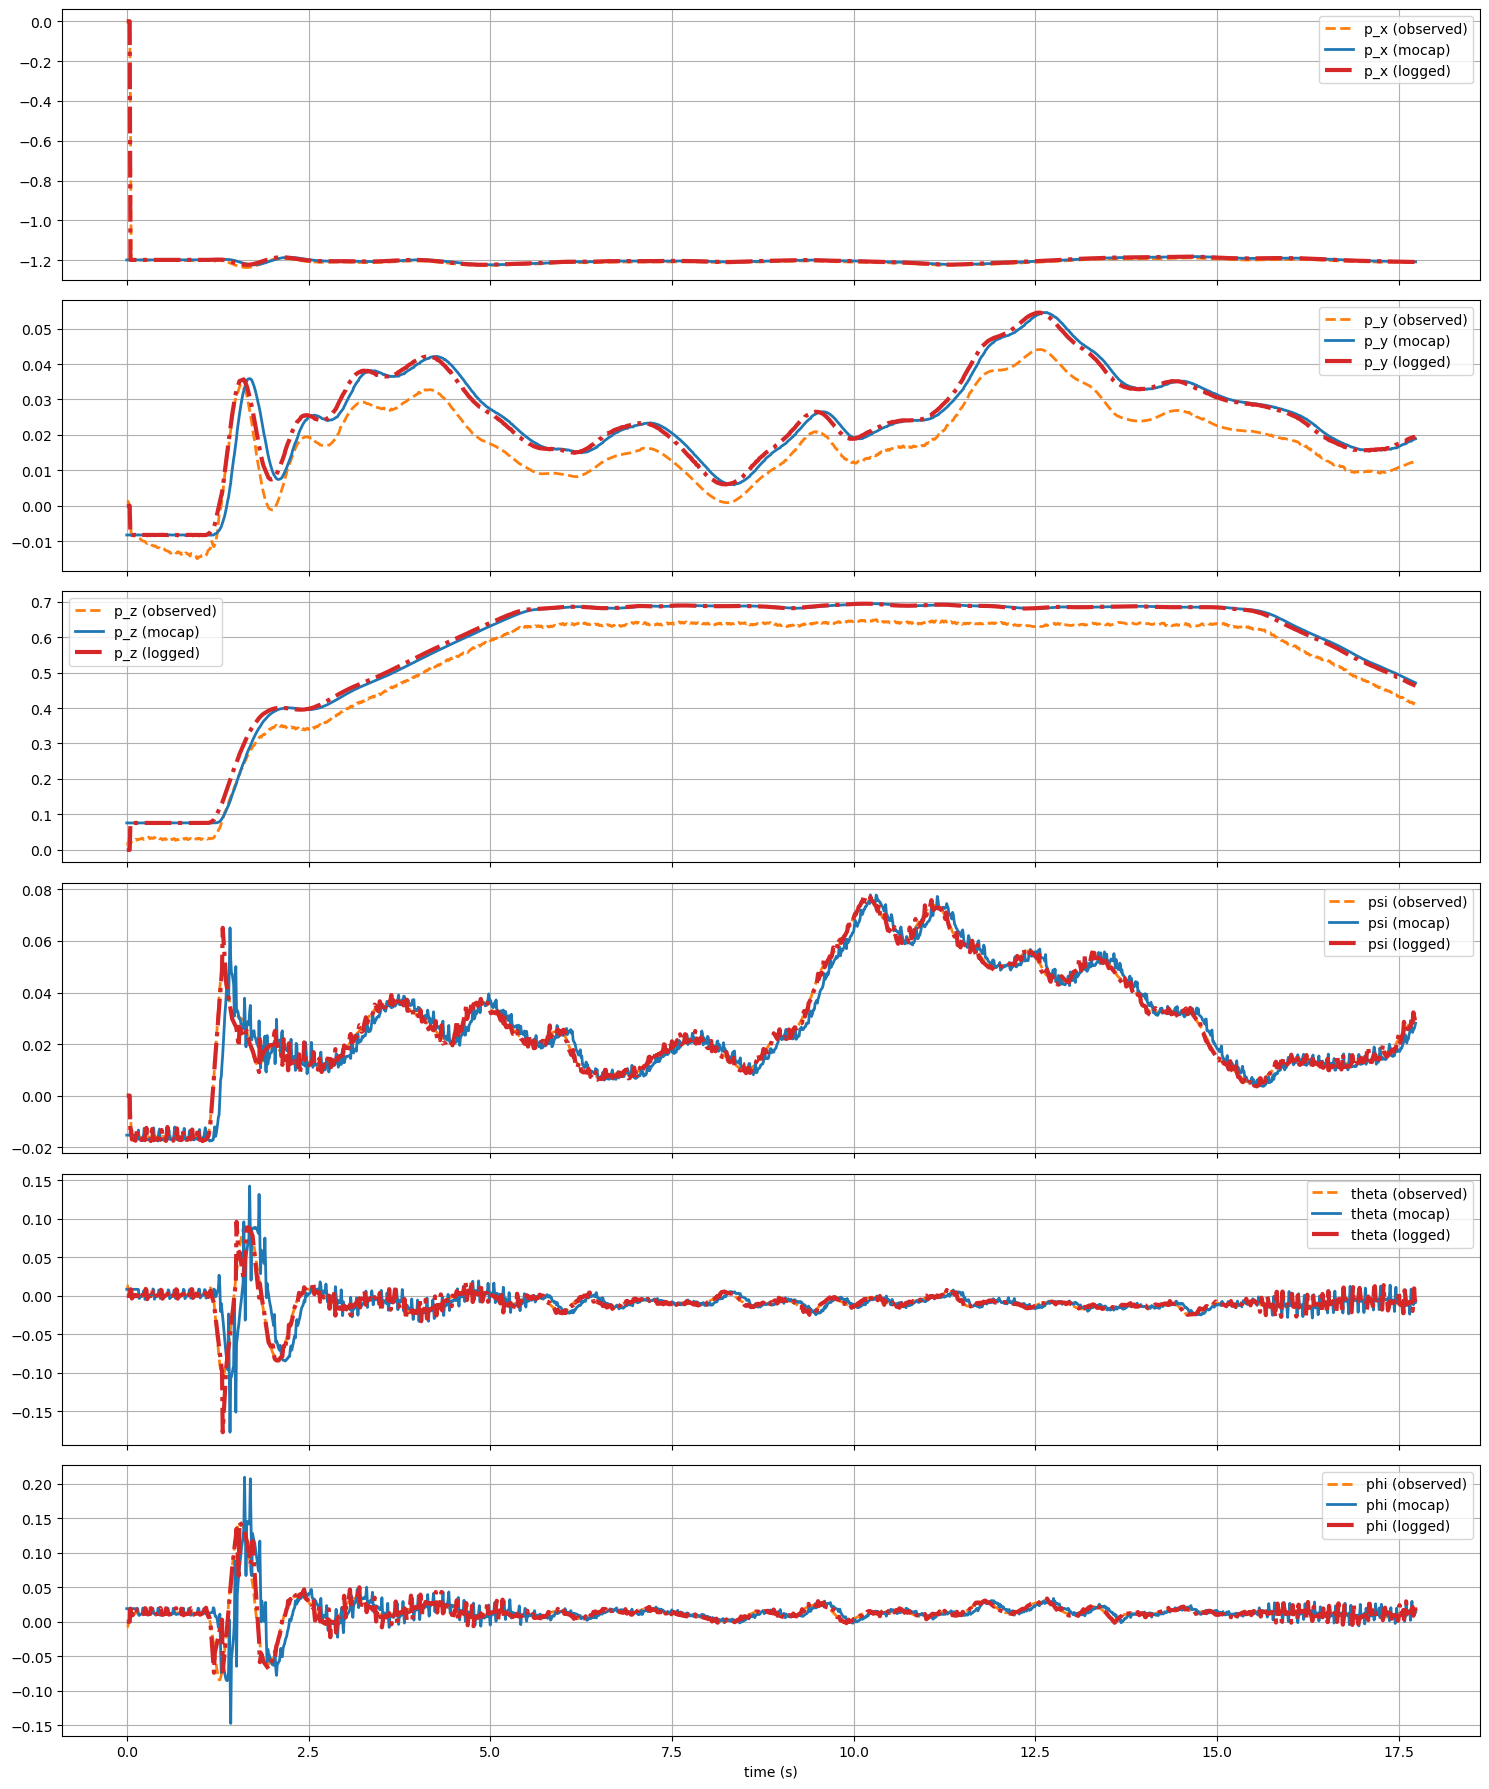

In [41]:
def comparison_plot(t, s_custom, s_default, s_mocap, name, ax, s_des=None):
    ax.plot(t, s_default, label=f'{name} (observed)',
            color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
    ax.plot(t, s_mocap, label=f'{name} (mocap)',
            color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
    ax.plot(t, s_custom, label=f'{name} (logged)',
            color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
    if s_des is not None:
        ax.plot(t, s_des, label=f'{name} (desired)',
                color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
    ax.legend()
    ax.grid()

fig, (ax_p_x,
      ax_p_y,
      ax_p_z,
      ax_psi,
      ax_theta,
      ax_phi) = plt.subplots(6, 1, figsize=(15, 18), sharex=True, tight_layout=True)
comparison_plot(t, p_x_mocap_logged, p_x_default, p_x_mocap, 'p_x', ax_p_x)
comparison_plot(t, p_y_mocap_logged, p_y_default, p_y_mocap, 'p_y', ax_p_y)
comparison_plot(t, p_z_mocap_logged, p_z_default, p_z_mocap, 'p_z', ax_p_z)
comparison_plot(t, psi_mocap_logged, psi_default, psi_mocap, 'psi', ax_psi)
comparison_plot(t, theta_mocap_logged, theta_default, theta_mocap, 'theta', ax_theta)
comparison_plot(t, phi_mocap_logged, phi_default, phi_mocap, 'phi', ax_phi)
ax_phi.set_xlabel('time (s)')
plt.show()

Plot top-down position and desired position (both from default and custom observer).

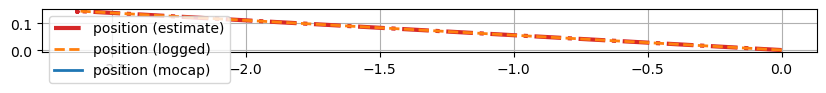

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(p_x, p_y, label='position (estimate)',
         color=custom_color, linestyle=custom_linestyle, linewidth=custom_linewidth)
ax.plot(p_x_mocap_logged, p_y_mocap_logged, label='position (logged)',
         color=default_color, linestyle=default_linestyle, linewidth=default_linewidth)
# ax.plot(p_x_des, p_y_des, label='position (desired)',
#          color=desired_color, linestyle=desired_linestyle, linewidth=desired_linewidth)
ax.plot(p_x_mocap, p_y_mocap, label='position (mocap)',
         color=mocap_color, linestyle=mocap_linestyle, linewidth=mocap_linewidth)
ax.set_aspect('equal')
ax.legend()
ax.grid()
plt.show()